In [1]:
import sys
import os
os.chdir('..')
sys.path.append('py//models')
from model_funs import *
X, y = get_x_y('data_for_modelling')
X_hold, y_hold = get_x_y('holdout')

In [2]:
def reverse_one_hot(X, col_patterns):
    X_new = X.copy()
    for single_pattern in col_patterns:
        cols = get_cols_with_pattern(X, f'{single_pattern}')
        df = X[cols]
        df[f'{single_pattern}'] = df.idxmax(axis=1).str.replace(f'{single_pattern}_', '')
    
        X_new = X_new.drop(columns = cols)
        X_new[f'{single_pattern}'] = df[f'{single_pattern}']
    
    return X_new

In [3]:
current_model = XGBRegressor(eval_metric = 'mae', 
                             tree_method='hist', 
                             device='cuda'
                 )
    
current_X = X.copy()
print("XGB check")
param_grid = {'n_estimators': np.arange(126, 128, 1), 
              'max_depth': np.arange(4, 6, 1),     
              'learning_rate': np.arange(0.13, 0.15, 0.01)
            }


grid_search = GridSearchCV(current_model, 
                           param_grid, 
                           cv = 5, 
                           scoring = 'neg_mean_absolute_error', 
                           return_train_score = False,
                           verbose = 1
             )

grid_search.fit(current_X, y)

XGB_best = grid_search.best_estimator_

print("Best Parameters:", grid_search.best_params_)
print("Best MAE: {:.2f}".format(-grid_search.best_score_))
print("")
print("")

XGB check
Fitting 5 folds for each of 8 candidates, totalling 40 fits


C:\Users\UBAN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:36:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'learning_rate': 0.14, 'max_depth': 5, 'n_estimators': 127}
Best MAE: 20714.40




In [4]:
errors = XGB_best.predict(X_hold) - y_hold
print(np.abs(errors).describe())
get_MAE(errors)
get_MAPE(errors, y_hold)

count     1000.0000
mean     20891.5202
std      24839.6833
min         13.9219
25%       5543.7119
50%      12657.5703
75%      25065.7852
max     191301.6250
Name: price, dtype: float64
MAE 20891.520162760415
MAPE 18.55644532136578%


0.18556445321365778

In [8]:
print(f"errors 95%: {np.quantile(errors, 0.95)}")
print(f"errors 5%: {np.quantile(errors, 0.05)}")

errors 95%: 44928.11757812495
errors 5%: -57911.103125


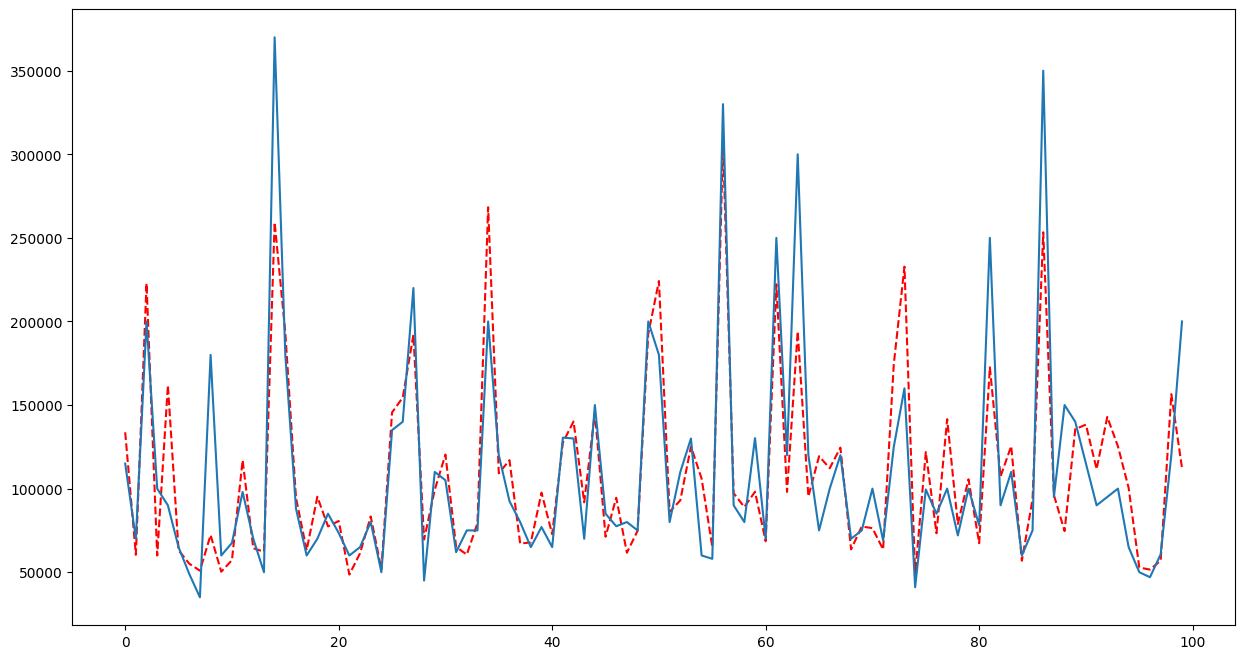

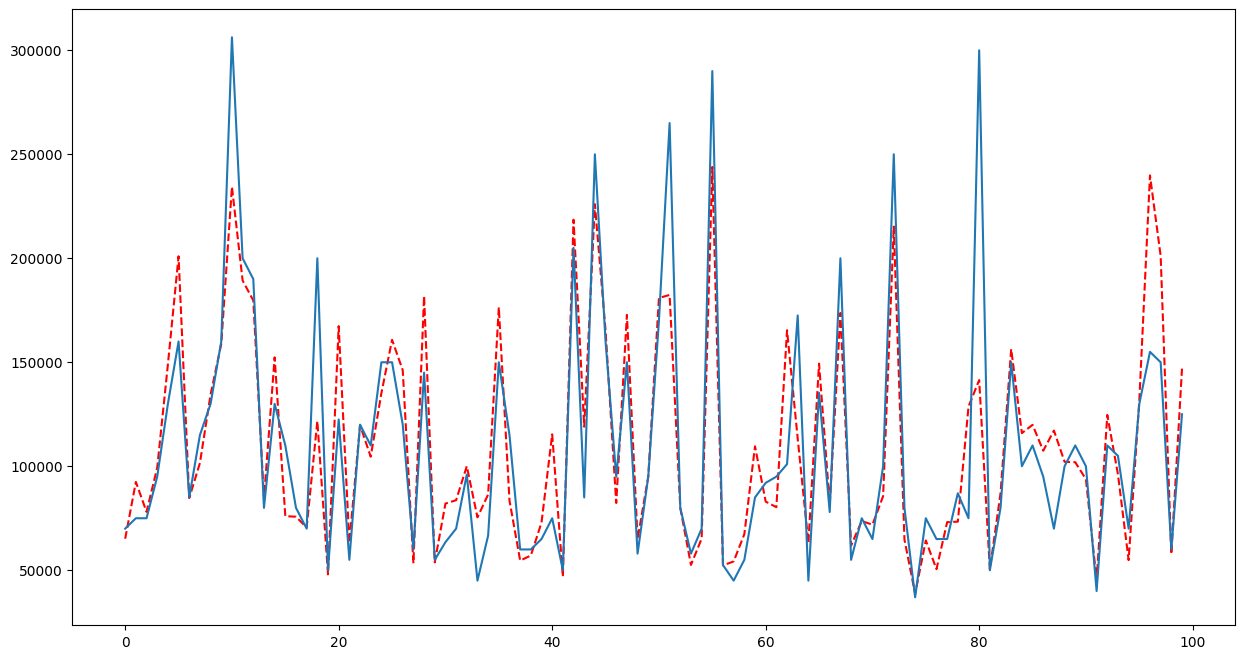

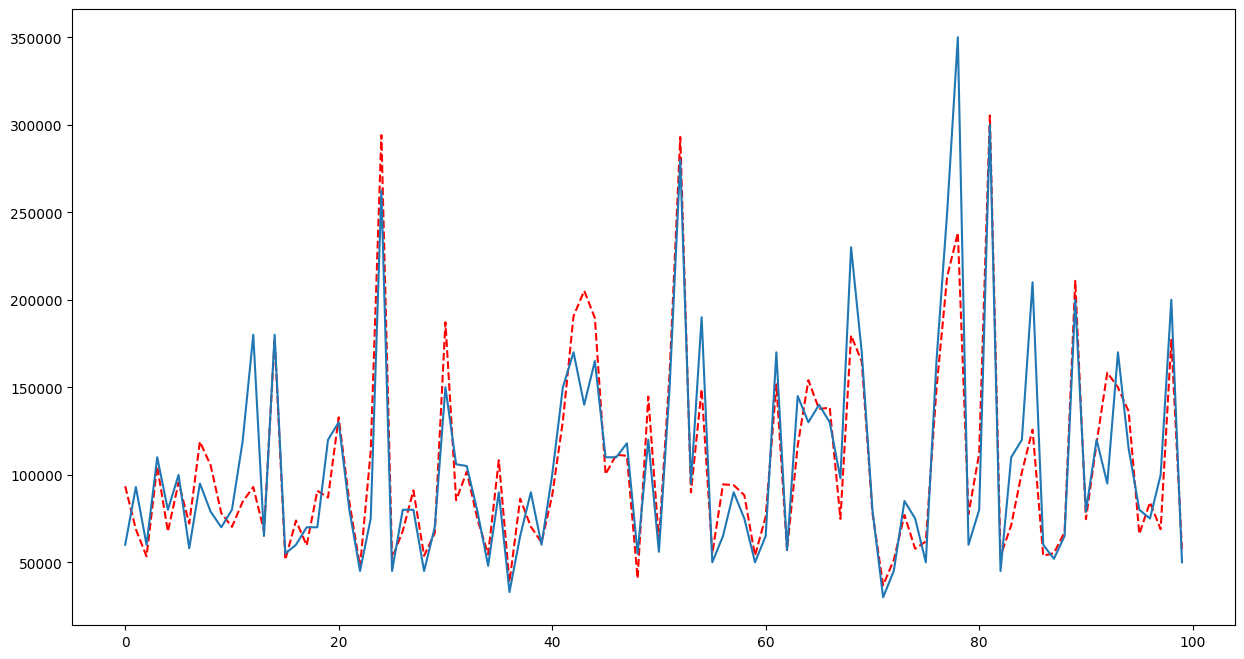

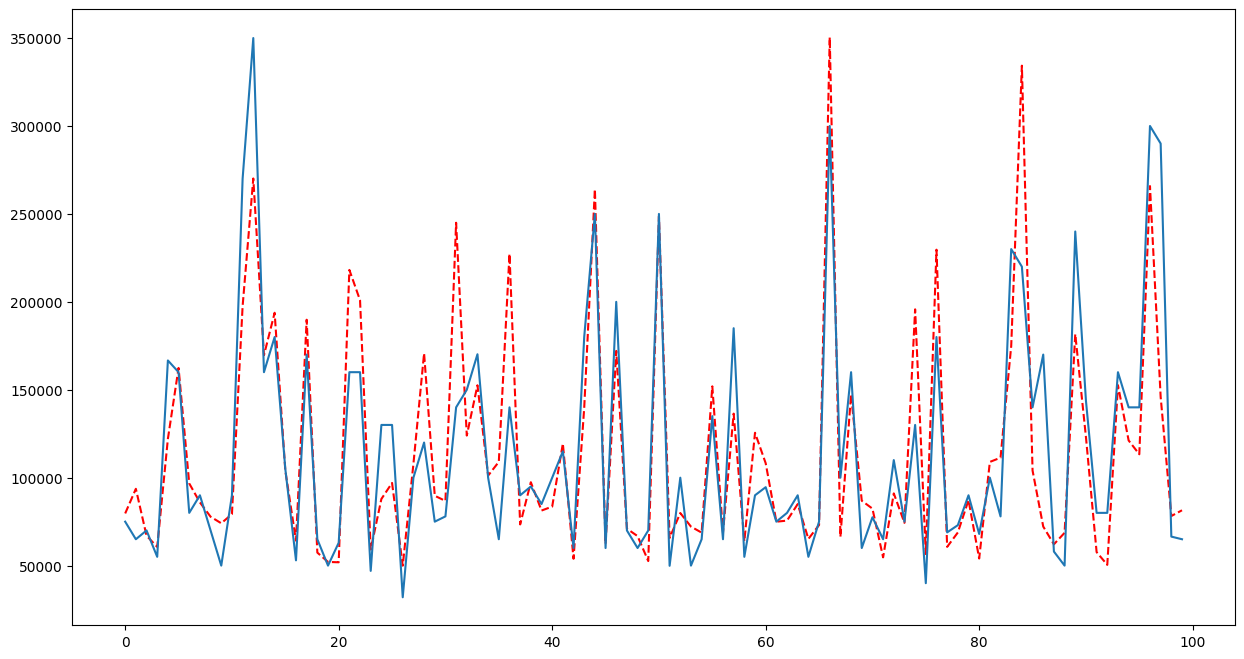

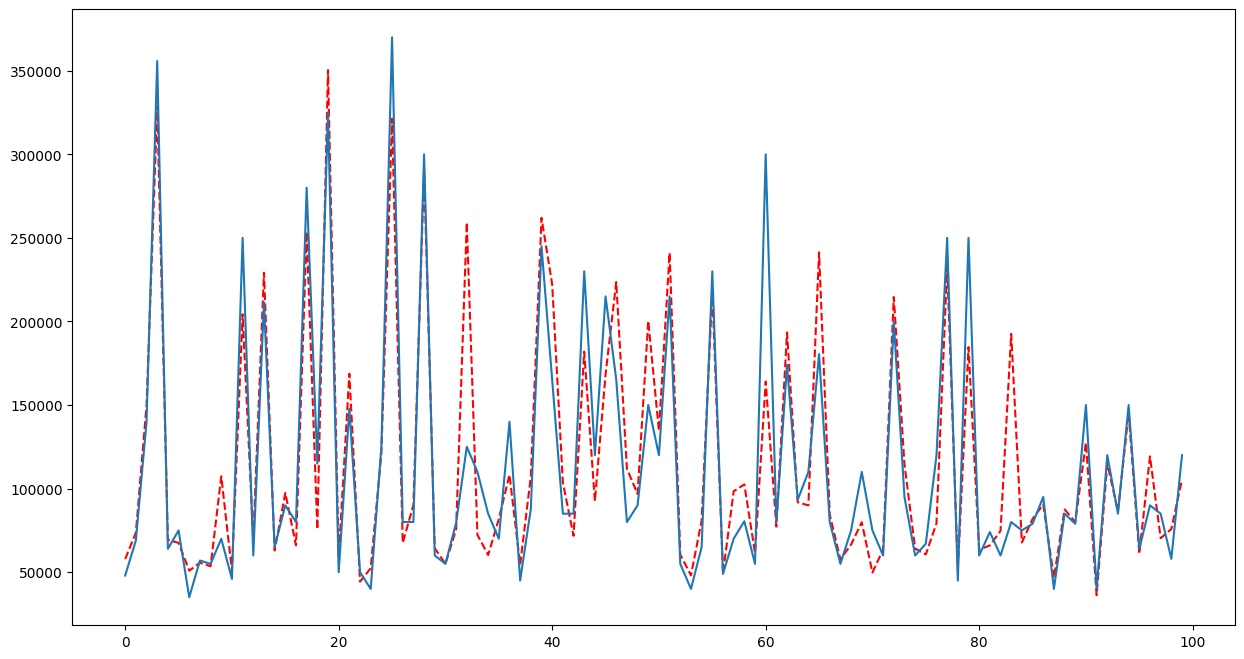

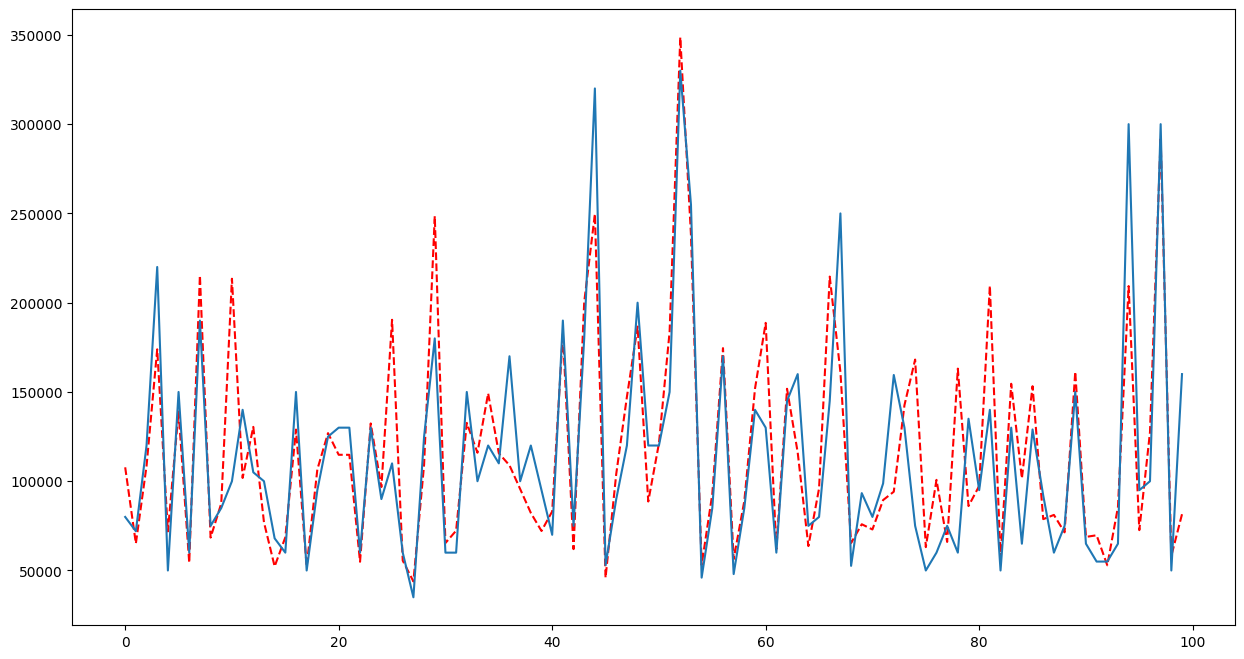

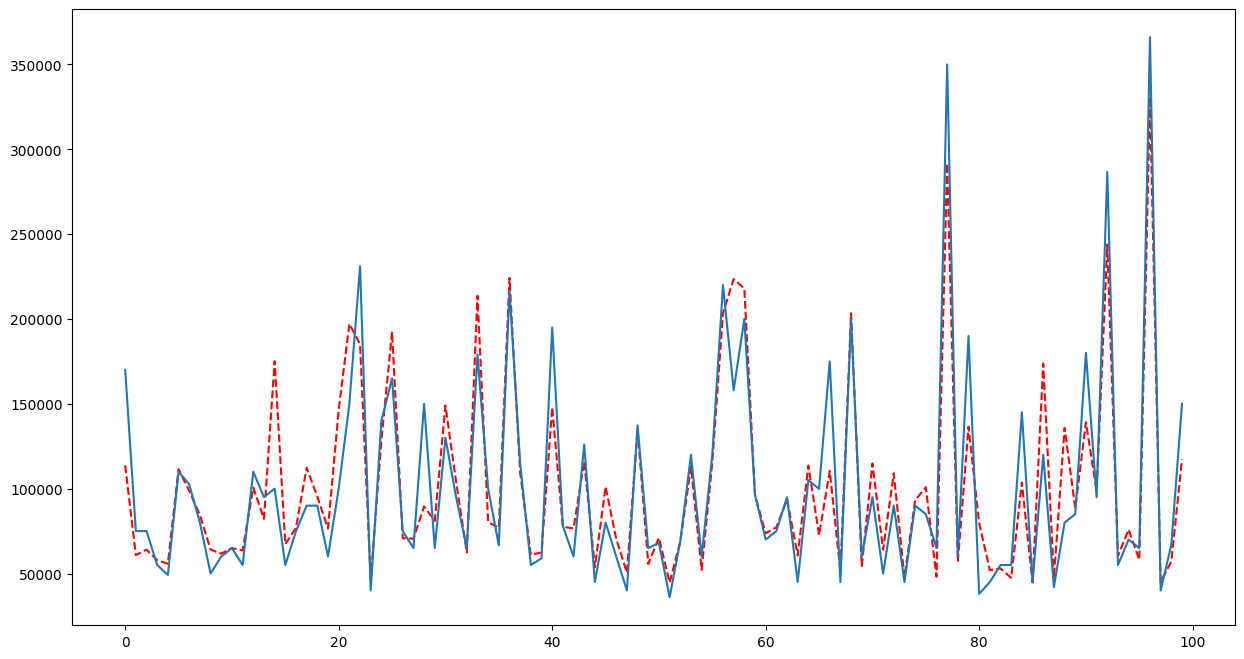

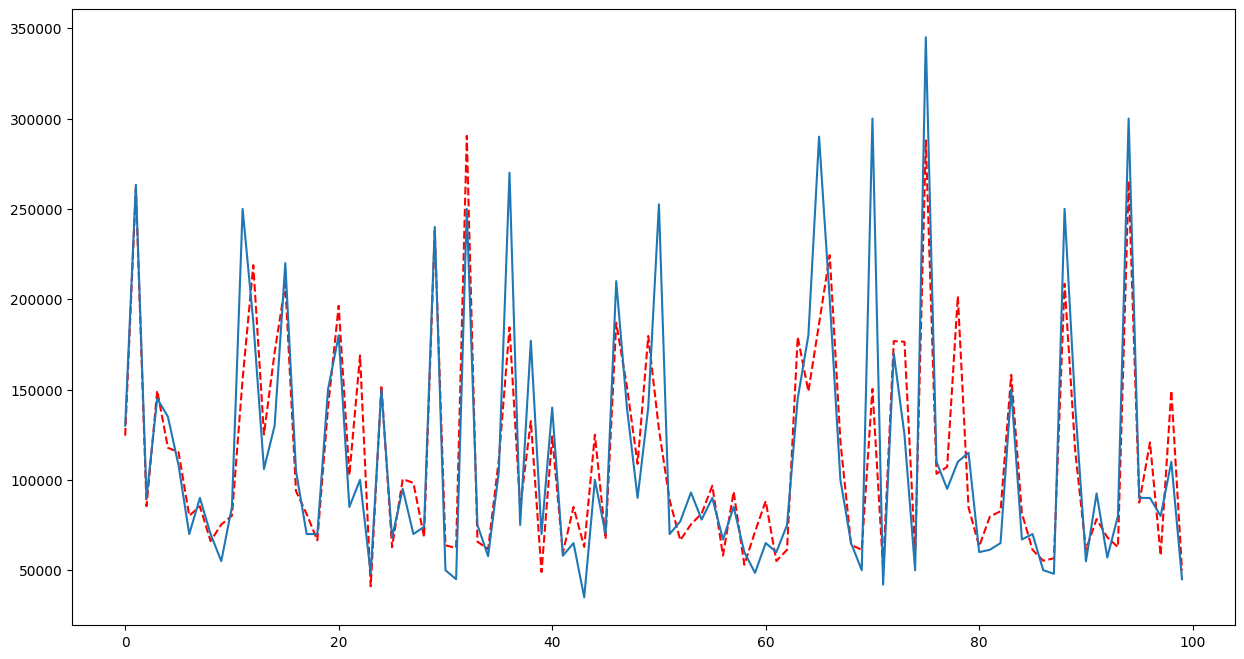

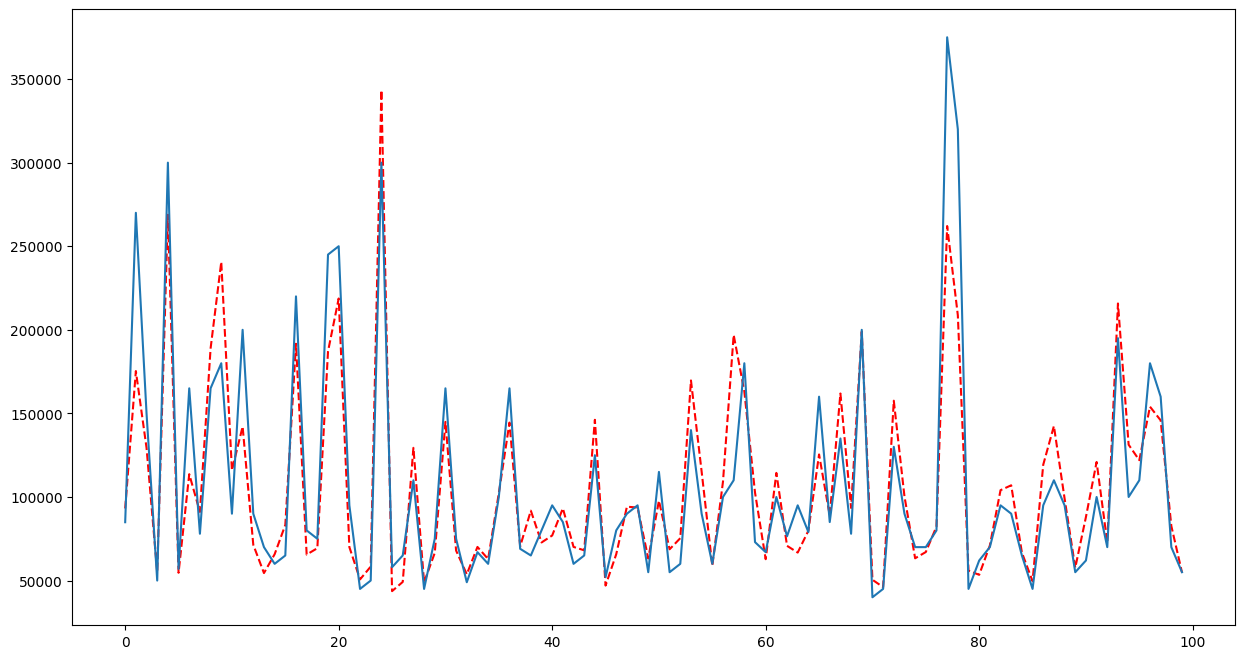

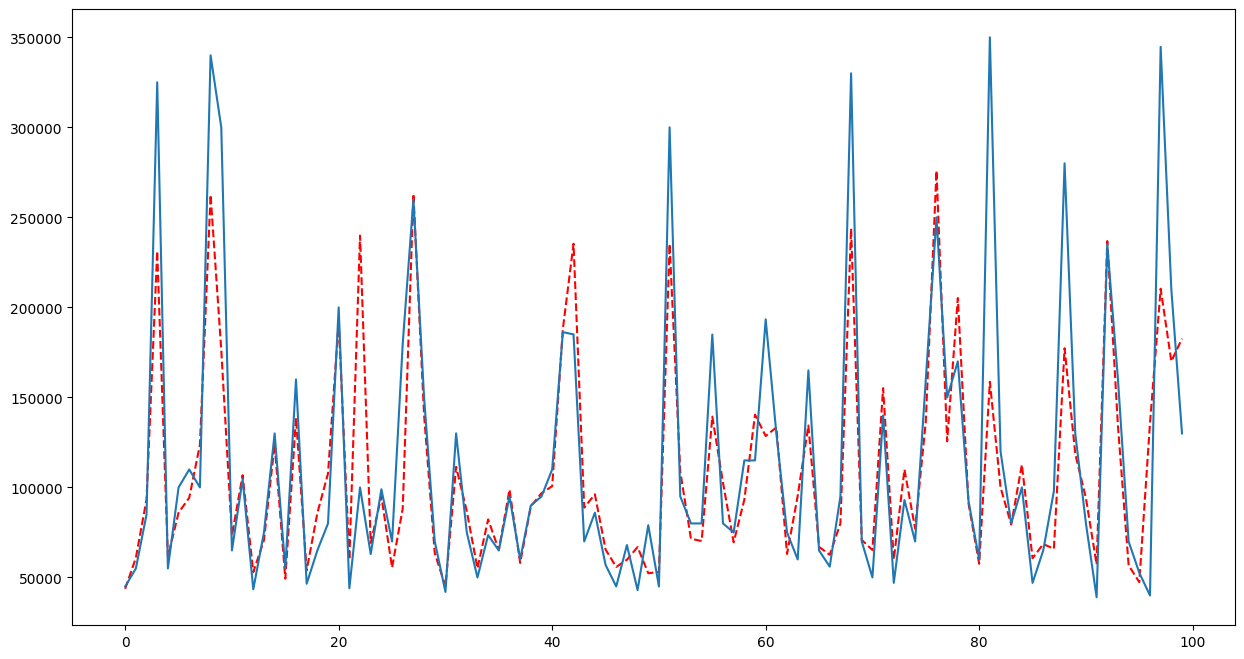

In [10]:
for num in np.arange(0, 1000, 100):
    plt.figure(figsize = (15, 8))
    plt.plot(range(100), XGB_best.predict(X_hold)[num:(num + 100)], color = 'red', linestyle = '--')
    plt.plot(range(100), y_hold[num:(num + 100)])
    plt.show()